In [1]:
# Load dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pymongo import MongoClient
from pprint import pprint

In [2]:
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Category20c
from math import pi
import plotly.express as px

Import data:
mongoimport --type csv -d SpotifyDataset -c SpotifySongs --headerline --drop project_3_clean.csv

In [19]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [20]:
# confirm database was created
print(mongo.list_database_names())

['SpotifyDataset', 'admin', 'config', 'spotify', 'spotifyData', 'spotifyTest']


In [21]:
# assign the database to a variable name
spotify_db = mongo['SpotifyDataset']

In [22]:
# review the collections in our new database
print(spotify_db.list_collection_names())

['SpotifySongs']


In [23]:
# review a document collection
print(spotify_db.SpotifySongs.find_one())

{'_id': ObjectId('6711b921c1425e20be8accee'), 'artist': 'blink-182', 'song': 'all the small things', 'duration_ms': 167066, 'explicit': 'False', 'year': 1999, 'popularity': 79, 'danceability': 44.51282051282051, 'energy': 89.7897897897898, 'key': 0, 'loudness': -4.918, 'mode': 1, 'speechiness': 8.472222222222223, 'acousticness': 1.1534154535274355, 'instrumentalness': 0.0, 'liveness': 71.74677608440797, 'valence': 70.29804727646454, 'tempo': 148.726, 'genre': 'rock', 'duration_minutes': 2.7844333333333333}


In [24]:
# assign the collection to a variable
songs = spotify_db['SpotifySongs']

In [25]:
# Display the number of documents 
songs.count_documents({})

1838

Kimberly's Code: Top 10 Artists by Song Count & Top Artist's Song Popularity Percentages

In [26]:
#Aggregate by artist
artists = [
    { 
        "$group": {
            "_id": "$artist",  # Group by the artist field
            "count": {"$sum": 1}  # Count the number of occurrences of each artist
        }
    },
    { 
        "$sort": {"count": -1}  # Sort by count in descending order
    },
    { 
        "$limit": 10  # Limit the result to the top artist
    }
]
results = list(songs.aggregate(artists))

In [27]:
# Output the top 10 artists with their counts
print("Top 10 artists:")
top_artists = []
for i, artist in enumerate(results, start=1):
    print(f"{i}. {artist['_id']} with {artist['count']} songs.")
    top_artists.append(artist['_id'])  # Store top artist names

Top 10 artists:
1. rihanna with 22 songs.
2. eminem with 21 songs.
3. calvin harris with 20 songs.
4. drake with 19 songs.
5. david guetta with 18 songs.
6. britney spears with 18 songs.
7. chris brown with 16 songs.
8. taylor swift with 16 songs.
9. kanye west with 16 songs.
10. katy perry with 16 songs.


In [35]:
rihanna_popularity = [
    { 
        "$match": {
            "artist": "rihanna"  # Match only songs where the artist is Rihanna
        }
    },
    { 
        "$project": {
            "song": 1,  # Include the song name
            "popularity": 1,  # Include the popularity field
        }
    },
    { 
        "$sort": {
            "popularity": -1  # Sort by popularity in descending order
        }
    }
]
# Execute the pipeline
rihanna_popularity_results = list(songs.aggregate(rihanna_popularity))

In [36]:
# Output the popularity of Rihanna's songs
print("Popularity of Rihanna's songs:")
for song in rihanna_popularity_results:
    print(f"Song: {song['song']}, Popularity: {song['popularity']}%")

Popularity of Rihanna's songs:
Song: umbrella, Popularity: 81%
Song: needed me, Popularity: 80%
Song: pon de replay, Popularity: 77%
Song: don't stop the music, Popularity: 77%
Song: disturbia, Popularity: 76%
Song: we found love, Popularity: 75%
Song: diamonds, Popularity: 75%
Song: work, Popularity: 75%
Song: take a bow, Popularity: 74%
Song: rude boy, Popularity: 74%
Song: sos, Popularity: 73%
Song: only girl (in the world), Popularity: 73%
Song: s&m, Popularity: 73%
Song: bitch better have my money, Popularity: 73%
Song: where have you been, Popularity: 71%
Song: unfaithful, Popularity: 70%
Song: shut up and drive, Popularity: 69%
Song: man down, Popularity: 68%
Song: te amo, Popularity: 67%
Song: what's my name?, Popularity: 66%
Song: russian roulette, Popularity: 64%
Song: hard, Popularity: 55%


Dylan's Code: Comparing Danceability vs. Energy of Every Song

In [43]:
# Define the fields for the x and y axes
x_field = 'danceability' 
y_field = 'energy'  

In [44]:
# Fetch data from the songs collection
data = list(songs.find({}, {x_field: 1, y_field: 1}))

In [45]:
# Extract x and y values
x_values = [item[x_field] for item in data]
y_values = [item[y_field] for item in data]

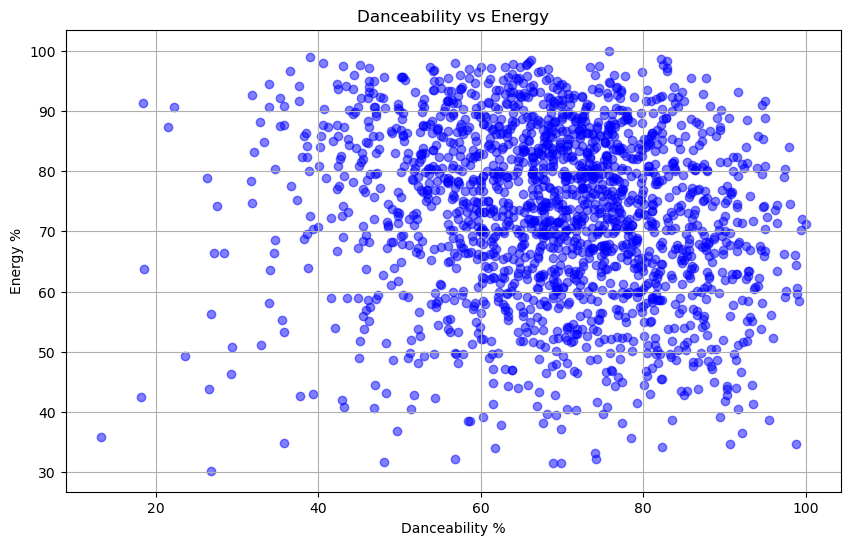

In [46]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color='blue', alpha=0.5)
plt.title('Danceability vs Energy')
plt.xlabel('Danceability %')
plt.ylabel('Energy %')
plt.grid(True)

# Show the plot
plt.show()

In [47]:
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [49]:
#Aggregate genre counts
genre_counts = list(songs.aggregate([
    {"$group": {"_id": "$genre", "count": {"$sum": 1}}},  # Group by genre and count
    {"$project": {"genre": "$_id", "count": 1}}  # Reshape the output
]))

In [50]:
#Convert DF 
genre_counts_df = pd.DataFrame(genre_counts)

In [51]:
#Prepare data for Bokeh
genre_counts_df['angle'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 2 * pi
genre_counts_df['color'] = Category20c[len(genre_counts_df)]

In [56]:
#Create the wedge plot
output_notebook()  
p = figure(outer_height=350, title="Song Genres Distribution", toolbar_location=None,
           tools="hover", tooltips="@genre: @count", x_range=(-0.5, 1.0))
p.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True),
         end_angle=cumsum('angle'), line_color="white", fill_color='color', legend_field='genre', 
         source=genre_counts_df)

# Add the circle
p.circle(x=0, y=1, radius=0.2, color="white")

# Adjust axis and grid visibility
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

# Show the plot
show(p)

Loading BokehJS ...